<a href="https://www.kaggle.com/code/jathinsreevas/digit-recogniser-using-basic-cnn?scriptVersionId=93812291" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical # for one hot encoding the target varibles
from keras.layers.convolutional import Conv2D # to add convolutional layers
from keras.layers.convolutional import MaxPooling2D # to add pooling layers
from keras.layers import Flatten # to flatten data for fully connected layers
from tensorflow.keras.layers import BatchNormalization # to maintain mean and sd close to 0 and 1 respectively

<h2> 1. Importing the Dataset </h2>
Let's import the train and test data into the pandas dataframe.

In [3]:
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
df_sub = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

<h2> 2. Checking the dataset </h2>
Let's see what we're dealing with here

In [4]:
print(df_train.shape)
print(df_test.shape)

(42000, 785)
(28000, 784)


In [5]:
df_train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2> 3. Data Wrangling </h2>

In [7]:
#Selecting the predictor and target variables
df_train_columns = df_train.columns
X_train = df_train[df_train_columns[df_train_columns != "label"]].to_numpy()
y_train = df_train['label'].to_numpy()

In [8]:
#Selecting the predictor and target variables
df_test_columns = df_test.columns
X_test = df_test.to_numpy()

In [9]:
#Reshape the obtained data into [shape][pixels][height][width]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype("float32")

In [10]:
#Normalization
X_train = X_train/255
X_test = X_test/255

In [11]:
print(X_train.shape)
print(y_train.shape)

(42000, 28, 28, 1)
(42000,)


In [12]:
#One-hot encoding
y_train = to_categorical(y_train)
y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [13]:
#Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

<h2> 4. Training and evaluating the model</h2>

In [14]:
def convolutional_model():
    model = Sequential()
    model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(48, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
#Fit the model
model = convolutional_model()
model.fit(X_train, y_train, epochs=40, batch_size=100, verbose=2)
scores = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1]*100, 100-scores[1]*100))

2022-04-23 17:01:42.416231: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-23 17:01:42.765622: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
336/336 - 10s - loss: 0.2106 - accuracy: 0.9360
Epoch 2/40
336/336 - 9s - loss: 0.0545 - accuracy: 0.9829
Epoch 3/40
336/336 - 9s - loss: 0.0334 - accuracy: 0.9897
Epoch 4/40
336/336 - 9s - loss: 0.0219 - accuracy: 0.9931
Epoch 5/40
336/336 - 8s - loss: 0.0166 - accuracy: 0.9943
Epoch 6/40
336/336 - 8s - loss: 0.0138 - accuracy: 0.9956
Epoch 7/40
336/336 - 8s - loss: 0.0093 - accuracy: 0.9974
Epoch 8/40
336/336 - 9s - loss: 0.0075 - accuracy: 0.9980
Epoch 9/40
336/336 - 8s - loss: 0.0086 - accuracy: 0.9972
Epoch 10/40
336/336 - 8s - loss: 0.0113 - accuracy: 0.9960
Epoch 11/40
336/336 - 8s - loss: 0.0055 - accuracy: 0.9983
Epoch 12/40
336/336 - 9s - loss: 0.0060 - accuracy: 0.9977
Epoch 13/40
336/336 - 8s - loss: 0.0060 - accuracy: 0.9983
Epoch 14/40
336/336 - 8s - loss: 0.0072 - accuracy: 0.9976
Epoch 15/40
336/336 - 9s - loss: 0.0082 - accuracy: 0.9975
Epoch 16/40
336/336 - 8s - loss: 0.0055 - accuracy: 0.9980
Epoch 17/40
336/336 - 8s - loss: 0.0054 - accuracy: 0.9982
Epoch

In [16]:
model.save('digit_model.h5', save_format='h5')

<h2> 5. Evaluation </h2>

In [17]:
# Evaluating the model
y_hat = model.predict(X_val)
y_hat = [np.argmax(i) for i in y_hat]
y_val = [np.argmax(i) for i in y_val]

Let us check if the first ten values in our validation set are matching with the predicted values

In [18]:
print("  Actual  :",y_val[:10])
print("Predicted :",y_hat[:10])

  Actual  : [8, 5, 2, 4, 2, 9, 4, 5, 1, 7]
Predicted : [8, 5, 2, 4, 2, 9, 4, 5, 1, 7]


Clearly, the first ten values match, proving that we have a good model.

In [19]:
matrix = tf.math.confusion_matrix(labels=y_val, predictions=y_hat)

Text(0.5, 1.0, 'Confusion Matrix')

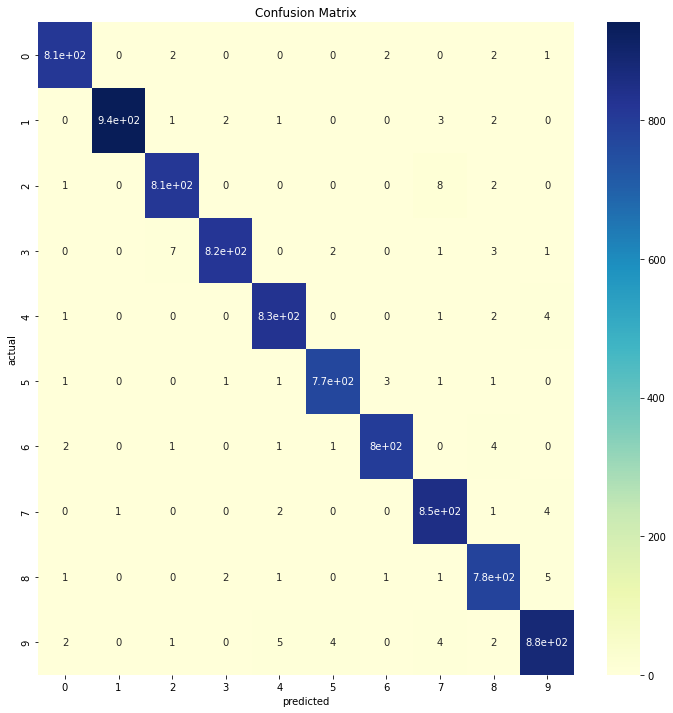

In [20]:
#Confusion matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.xlabel("predicted")
plt.ylabel('actual')
plt.title('Confusion Matrix')

<h2> 6. Submission </h2>

In [21]:
#Predicting the test cases
y_new = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_new]

In [22]:
df_sub['Label'] = y_pred
df_sub.head(5)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [23]:
df_sub.to_csv('submission.csv', index=False)

<p> Thanks to the <a hef="https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1" style="color: blue">notebook</a> shared by Kassem and the <a href="https://www.coursera.org/learn/introduction-to-deep-learning-with-keras" style="color: blue">Keras introductory course</a> by IBM on coursera for making the concepts easier.</p>